In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import os 
import matplotlib.pyplot as plt
from datetime import datetime
# import seaborn as sns

os.getcwd()

'/home/mgteus/workspace/neuro/transformers_andrej'

In [2]:
from attention_model import Head, get_batch1d, get_batch2d, RMSELoss, MultiHeadAttention, get_dataloader, PositionEncoding, Transformers

In [3]:
# from torchtune.modules import RotaryPositionalEmbeddings

In [4]:
np.random.random()

0.5138247586108281

In [27]:
CONTEXT_LEN = 128
BATCH_SIZE = 2028
DROPOUT = 0.1
LEARNING_RATE = 1e-4
NUM_HEADS = 2
HEAD_SIZE = 1
NUM_EPOCHS = 1e4
NUM_BLOCKS = 2
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [28]:
DEVICE, NUM_EPOCHS

('cuda', 10000.0)

In [29]:
model = Transformers(num_blocks=NUM_BLOCKS,
                        num_heads = NUM_HEADS
            , context_len = CONTEXT_LEN
            , batch_size = BATCH_SIZE
            , dropout = DROPOUT
            , head_output_dim=HEAD_SIZE)

model = model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [30]:
# Criar o DataLoader
dataloader = get_dataloader(split='train', batch_size=BATCH_SIZE, context_len=CONTEXT_LEN, device=DEVICE)

In [31]:
loss_list = []
epoch = 0
print('starting training', datetime.now())
for xb, yb in dataloader:
    while epoch <= NUM_EPOCHS:
        # xb, yb = get_batch2d(context_len=CONTEXT_LEN, batch_size=BATCH_SIZE, split='train', device=DEVICE)
        optimizer.zero_grad(set_to_none=True)
        predictions = model(xb)
        predictions = predictions.to(DEVICE)
        # print(predictions.shape)
        loss = RMSELoss(predictions.view(BATCH_SIZE*CONTEXT_LEN, NUM_HEADS), yb.view(BATCH_SIZE*CONTEXT_LEN, NUM_HEADS))
        # print(loss)
        loss.backward()
        optimizer.step()
        loss_list.append(loss.cpu().detach().numpy())
        if epoch%(NUM_EPOCHS/10)==0:
            print(f"iter. {epoch} - loss = {loss.item():4f}", datetime.now())
        epoch+=1
print('end train', datetime.now())

starting training 2024-12-01 11:09:20.621814
iter. 0 - loss = 0.575941 2024-12-01 11:09:21.152609
iter. 1000 - loss = 0.283766 2024-12-01 11:10:15.079317
iter. 2000 - loss = 0.201557 2024-12-01 11:11:44.811907
iter. 3000 - loss = 0.144704 2024-12-01 11:13:17.528256
iter. 4000 - loss = 0.102642 2024-12-01 11:14:53.669095
iter. 5000 - loss = 0.069817 2024-12-01 11:16:29.726001
iter. 6000 - loss = 0.041391 2024-12-01 11:18:05.753780
iter. 7000 - loss = 0.012656 2024-12-01 11:19:42.802107
iter. 8000 - loss = 0.008499 2024-12-01 11:21:14.895663
iter. 9000 - loss = 0.008473 2024-12-01 11:22:51.320116
iter. 10000 - loss = 0.008465 2024-12-01 11:24:25.173080
end train 2024-12-01 11:24:28.262071


In [34]:
loss.cpu().detach().numpy()

array(0.00846514, dtype=float32)

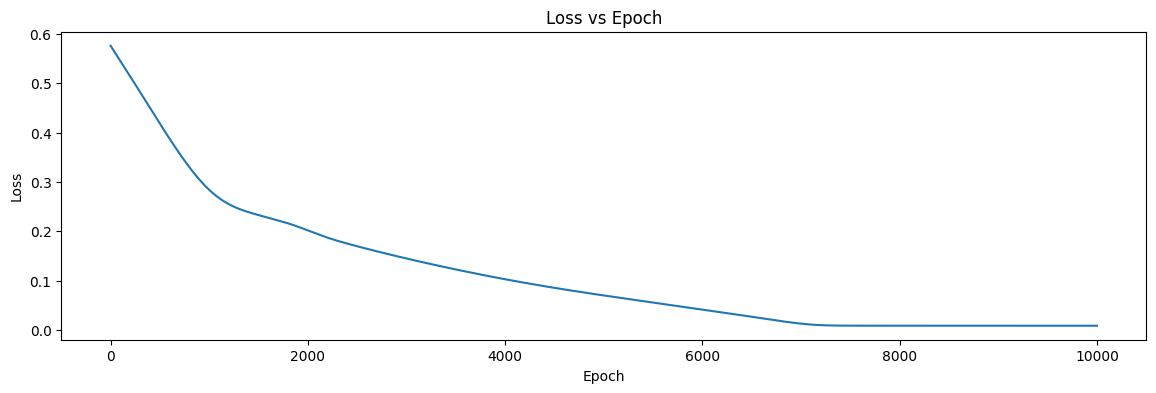

In [35]:
fig, ax = plt.subplots(figsize=(14,4))
plt.plot(loss_list)
plt.title('Loss vs Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [36]:
np.std(loss_list)

0.12898964

In [37]:
# Criar o DataLoader
dataloader_test = get_dataloader(split='test', batch_size=BATCH_SIZE, context_len=CONTEXT_LEN, device=DEVICE)

In [38]:
for txb, tyb in dataloader_test:
    break

In [39]:
txb.shape, tyb.shape

(torch.Size([2028, 128, 2]), torch.Size([2028, 128, 2]))

In [40]:
tpredb = model(txb)

In [58]:
tpred = model(txb).cpu().detach().numpy()
ty = tyb.cpu().detach().numpy()
tx = txb.cpu().detach().numpy()
tpred.shape, ty.shape, tx.shape

((2028, 128, 2), (2028, 128, 2), (2028, 128, 2))

In [42]:
tx[0, 0:3, :]

array([[0.40825537, 0.6210186 ],
       [0.4154797 , 0.6108196 ],
       [0.4197388 , 0.6076578 ]], dtype=float32)

In [67]:
tpred[0, 0:4,:]

array([[0.409377  , 0.61969936],
       [0.4136969 , 0.6104996 ],
       [0.41672266, 0.60829824],
       [0.42141637, 0.60437745]], dtype=float32)

In [56]:
tpred[0, 2,:]

array([0.41672266, 0.60829824], dtype=float32)

In [65]:
ty[0,2,:]

array([0.42392227, 0.60330725], dtype=float32)

In [74]:
for i in range(1,4):
    print(model(txb[0:1,0:i,:])[0,-1,:].cpu().detach().numpy())

[0.40937704 0.61969936]
[0.41666445 0.6094613 ]
[0.4209524 0.6062884]


In [52]:
CONTEXT_LEN//16

8

In [93]:
for i in range(1, CONTEXT_LEN):
    plt.title(f'Plot Batch 0 | step {i:03d}')
    plt.scatter(tx[0,0:i, 0], tx[0,0:i, 1],  label='Context', c=[color for color in range(len(tx[0,0:i, 0]))], alpha=0.4, marker='^')
    model_prediction = model(txb[0:1,0:i,:])[0,-1,:].cpu().detach().numpy()
    plt.scatter(model_prediction[0], model_prediction[1], label='prediction', c='r')
    plt.scatter(ty[0, i-1:i,0], ty[0, i-1:i,1], label='True', c='k', marker='^')
    plt.legend()
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.colorbar(label='% context steps')
    plt.ylim(0, 1)
    plt.xlim(0,1)
    plt.savefig(f'/home/mgteus/workspace/neuro/transformers_andrej/plots/gifs/step{i:03d}_fix.png', format='png')
    plt.close()

    # plt.show()

In [95]:
import glob
import os
from PIL import Image


# filepaths

fp_in =  f'/home/mgteus/workspace/neuro/transformers_andrej/plots/gifs/**_fix.png'
fp_out =  f'/home/mgteus/workspace/neuro/transformers_andrej/plots/test_run_fix_20s.gif'

# https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
img, *imgs = [Image.open(f) for f in sorted(glob.glob(fp_in))]
img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=200, loop=0)

In [9]:
key_weight = model.key.weight.detach().numpy()
query_weight = model.query.weight.detach().numpy()
values_weight = model.values.weight.detach().numpy()

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))

sns.heatmap(key_weight, cmap='viridis', ax=ax[0])
ax[0].set_title('Key Weights')

sns.heatmap(query_weight, cmap='viridis', ax=ax[1])
ax[1].set_title('Query Weights')

sns.heatmap(values_weight, cmap='viridis', ax=ax[2])
ax[2].set_title('Values Weights')
plt.show()